# Machine Learning: Supervised Learning

Material for the [2018 Asterics and Obelics School](https://indico.in2p3.fr/event/16864/): [Table of Contents](Contents.ipynb)

Content is maintained on [github](https://github.com/Asterics2020-Obelics/School2018/tree/master/machinelearning) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

![sponsor-logos](img/sponsor-logos.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import neighbors, svm, ensemble, linear_model, metrics, model_selection, preprocessing

In [3]:
from mls import plot_image, plot_classification, scan_misclassified, plot_regression

Load the images we generated earlier:

In [4]:
df_img = pd.read_hdf('data/sources_img.hf5')

Since this is **supervised learning**, we are going to augment our training data with some "labels" that we can learn to predict in new data.

Use the true parameters values to label our generated images so we can learn to predict these parameters in real images:

In [5]:
df_par = pd.read_hdf('data/sources_par.hf5')

## Types of Supervised Learning

It is useful to distinguish between discrete and continuous labels since they generally require different algorithms:
- **classification:** label features are discrete (boolean, integer, categorical).
- **regression:** label features are continuous.

However, since labels can be multi-dimensional hybrids of discrete and continuous features, not all supervised learning falls into these categories.

### Supervised Learning: Classification

To demonstrate classification algorithms, we will learn to classify an image according to how many sources its contains:

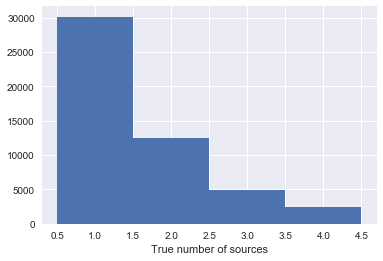

In [6]:
nsrc_true = df_par['num_source']
plt.hist(nsrc_true, bins=4, range=(0.5, 4.5))
plt.xlabel('True number of sources');

### Supervised Learning: Regression

To demonstrate regression algorithms, we will learn to predict the shear magnitude 
$$
e \equiv \sqrt{e_1^2 + e_2^2}
$$
from "isolated" images containing only one source:

In [7]:
isolated = df_par['num_source'] == 1
print(f'Using {np.count_nonzero(isolated)} isolated sources for regression.')
df_iso = df_img[isolated]

Using 30158 isolated sources for regression.


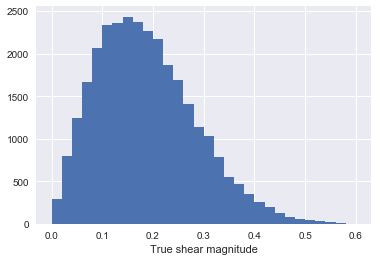

In [8]:
e1 = np.hstack(df_par[isolated]['e1'].values)
e2 = np.hstack(df_par[isolated]['e2'].values)
e_true = np.sqrt(e1 ** 2 + e2 ** 2)
plt.hist(e_true, range=(0,0.6), bins=30)
plt.xlabel('True shear magnitude');

## Generalization

A model with enough parameters can effectively memorize the data it is trained on, but this **overfitting** is usually not what you want. Instead, you usually care most about how well your model **generalizes** to data that it has never seen.

A straightforward method to measure a model's ability to generalize is the **train-test split**:
 - Split your available data into separate training and test subsets.
 - Learn the model using only the training data.
 - Measure the accuracy of predicted labels on both the training and test data.
 
The best case is that both subsets have the same accuracy. Otherwise, you are overfitting to some degree.

Notes:
 - You usually have to sacrifice some accuracy on the training data to improve generalization.
 - The train-test split method does not to avoid overfitting, it just provides a way to measure it.
 - When you don't have much data, it is tempting to use it all for training. Don't do this.
 
There is no rigorous procedure for setting an optimum test fraction, and anything between 0.1 and 0.5 would be reasonable.  A larger test fraction improves the reliability of the test metric but decreases the reliability of the model being tested.

As always, more data always helps and reduces your sensitivity to your choice of training fraction.

### Train-Test Split

The [sklearn train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function picks a random fraction of the observed data to hold back when learning the model and then use for later testing. This is expensive (since it requires more data) but necessary to avoid overfitting the training data.

Note that since train/test splitting involves random numbers, you will need to pass around a random state object for reproducible results.

Split our image and label datasets using the sklearn default 25% test fraction. Note the use of `random_state` to ensure reproducible "randomness":

In [9]:
df_img_train, df_img_test, nsrc_true_train, nsrc_true_test = model_selection.train_test_split(
    df_img, nsrc_true, test_size=0.25, random_state=123)
df_iso_train, df_iso_test, e_true_train, e_true_test = model_selection.train_test_split(
    df_iso, e_true, test_size=0.25, random_state=123)

Check that the training and test labels are (statistically) equivalent:

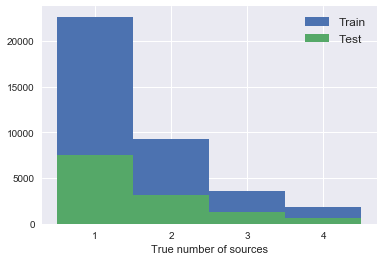

In [10]:
plt.hist(nsrc_true_train, bins=4, range=(0.5, 4.5), label='Train')
plt.hist(nsrc_true_test, bins=4, range=(0.5, 4.5), label='Test')
plt.xticks([1, 2, 3, 4])
plt.legend(fontsize='large')
plt.xlabel('True number of sources');

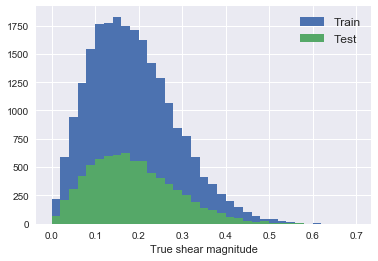

In [11]:
plt.hist(e_true_train, range=(0,0.7), bins=35, label='Train')
plt.hist(e_true_test, range=(0,0.7), bins=35, label='Test')
plt.legend(fontsize='large')
plt.xlabel('True shear magnitude');

## Preprocessing

Some algorithms assume that their input features and regression targets are roughly centered on zero with unit variance.  These assumptions are usually not strictly necessary and sometimes not well documented.

If you want to be able to quickly try different algorithms, you usually need to do some preprocessing of your data first.

The sklearn [preprocessing module](http://scikit-learn.org/stable/modules/preprocessing.html) provides useful building blocks for preprocessing data to achieve this. For example, to scale our shear target values, create a scaling object using the training data, then apply it to both the test and training data. (Why?)

In [12]:
e_scaler = preprocessing.StandardScaler().fit(e_true_train.reshape(-1, 1))

In [13]:
e_scaled_train = e_scaler.transform(e_true_train.reshape(-1, 1)).reshape(-1)
e_scaled_test = e_scaler.transform(e_true_test.reshape(-1, 1)).reshape(-1)
e_scaled = e_scaler.transform(e_true.reshape(-1, 1)).reshape(-1)

The scaled distributions have the same shape, but are now roughly centered on zero and have unit variance:

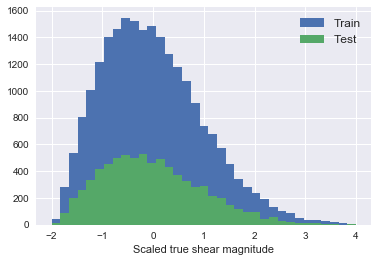

In [14]:
plt.hist(e_scaled_train, range=(-2, 4), bins=35, label='Train')
plt.hist(e_scaled_test, range=(-2, 4), bins=35, label='Test')
plt.legend(fontsize='large')
plt.xlabel('Scaled true shear magnitude');

Note that a scaler transformation is invertible, which is useful for interpreting scaled predictions:

In [15]:
assert np.allclose(e_true_test, e_scaler.inverse_transform(e_scaled_test))

We could perform a similar scaling of the images. However, the `StandardScaler` scales each pixel independently and effectively wipes out information about which pixels have no signal and distorts the shape of each source:

In [16]:
img_scaler = preprocessing.StandardScaler().fit(df_img_train)
df_img_train_scaled = img_scaler.transform(df_img_train)
assert np.allclose(np.mean(df_img_train_scaled, axis=0), 0)
assert np.allclose(np.std(df_img_train_scaled, axis=0), 1)
df_img_test_scaled = img_scaler.transform(df_img_test)

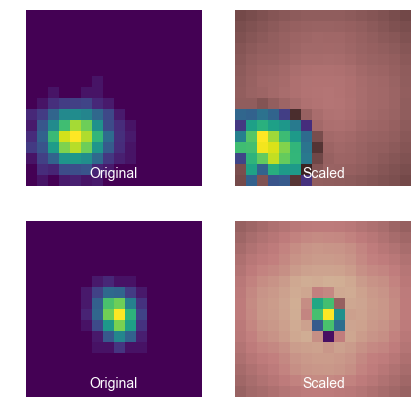

In [17]:
_, ax = plt.subplots(2, 2, figsize=(6, 6))
for row, idx in enumerate((6, 10)):
    plot_image(df_img_train.iloc[idx].values, ax=ax[row, 0], label='Original')
    plot_image(df_img_train_scaled[idx], ax=ax[row, 1], label='Scaled')
plt.tight_layout()

As an alternative, we perform a simpler preprocessing to normalize pixel values to be of order one while preserving zeros and the relative scaling of pixels within an image:

In [18]:
img_norm = np.std(df_img_train.values)
print(f'Scaling pixel values by {img_norm:.1f}')
df_img_train_normed = df_img_train.copy()
df_img_train_normed /= img_norm
assert np.allclose(np.std(df_img_train_normed.values), 1)
df_img_test_normed = df_img_test.copy()
df_img_test_normed /= img_norm
df_img_normed = df_img.copy()
df_img_normed /= img_norm

Scaling pixel values by 81.5


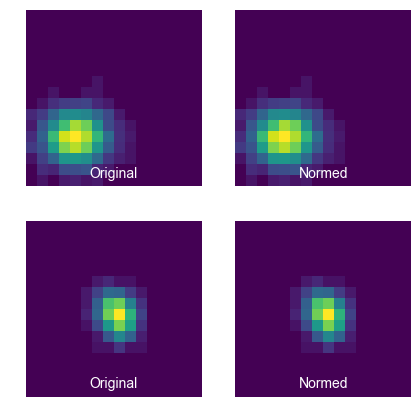

In [19]:
_, ax = plt.subplots(2, 2, figsize=(6, 6))
for row, idx in enumerate((6, 10)):
    plot_image(df_img_train.iloc[idx].values, ax=ax[row, 0], label='Original')
    plot_image(df_img_train_normed.iloc[idx].values, ax=ax[row, 1], label='Normed')
plt.tight_layout()

Perform the same normalization on the subset of images with a single source:

In [20]:
iso_scaler = preprocessing.StandardScaler().fit(df_iso_train)
df_iso_train_scaled = iso_scaler.transform(df_iso_train)
df_iso_test_scaled = iso_scaler.transform(df_iso_test)

In [21]:
iso_norm = np.std(df_iso_train.values)
print(f'Scaling isolated pixel values by {iso_norm:.1f}')
df_iso_train_normed = df_iso_train.copy()
df_iso_train_normed /= iso_norm
df_iso_test_normed = df_iso_test.copy()
df_iso_test_normed /= iso_norm
df_iso_normed = df_iso.copy()
df_iso_normed /= iso_norm

Scaling isolated pixel values by 60.6


Save the data we will reuse with neural networks later:

In [22]:
df_img_test.to_hdf('data/sources_img_test.hf5', 'img', mode='w')
df_img_test_normed.to_hdf('data/sources_img_test_normed.hf5', 'img', mode='w')
df_img_train_normed.to_hdf('data/sources_img_train_normed.hf5', 'img', mode='w')
nsrc_true_test.to_hdf('data/nsrc_true_test.hf5', 'nsrc', mode='w')
nsrc_true_train.to_hdf('data/nsrc_true_train.hf5', 'nsrc', mode='w')

In [23]:
df_iso_test_normed.to_hdf('data/sources_iso_test_normed.hf5', 'iso', mode='w')
df_iso_train_normed.to_hdf('data/sources_iso_train_normed.hf5', 'iso', mode='w')
pd.DataFrame(e_scaled_test).to_hdf('data/e_scaled_test.hf5', 'e', mode='w')
pd.DataFrame(e_scaled_train).to_hdf('data/e_scaled_train.hf5', 'e', mode='w')
pd.DataFrame(e_true_train).to_hdf('data/e_true_train.hf5', 'e', mode='w')
pd.DataFrame(e_true_test).to_hdf('data/e_true_test.hf5', 'e', mode='w')

## Classification

We are now ready to try some classical classification algorithms. We will use the following driver to quickly test different methods:

In [24]:
def test_sk_classification(
    method, train_data=df_img_train_normed, test_data=df_img_test_normed):
    # Fit normed training images.
    fit = method.fit(train_data, nsrc_true_train)
    # Get training predictions.
    nsrc_train = fit.predict(train_data)
    plot_classification(nsrc_train, nsrc_true_train, label='train:')
    plt.show()
    # Get test predictions.
    nsrc_test = fit.predict(test_data)
    plot_classification(nsrc_test, nsrc_true_test, label='test:')
    plt.show()
    # Scan some test failures.
    scan_misclassified(nsrc_test, nsrc_true_test, df_img_test)
    plt.show()
    # Return the test predictions.
    return nsrc_test

We won't have time to delve into the theory behind each method but I provide some links below for futher reading.

Understanding a method's internals can sometimes help with using it more effectively, but you will also be in good company if you dive in and just try things until you find a method that is "good enough".

We will generally use each method's default parameters for the examples below, and then discuss how to validate and optimize those defaults later.

### Nearest-Neighbor Classification

This is the simplest method you could image (so always a good choice for getting your initial baseline):
 - Find the "nearest" $k$ neighbors (using a Euclidean norm in feature space).
 - Use the most popular classification among the neighbors.

For details see [wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and the [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

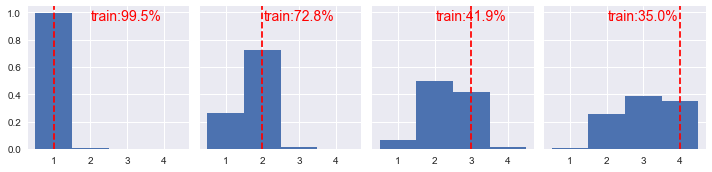

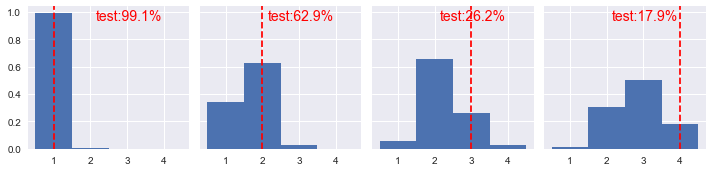

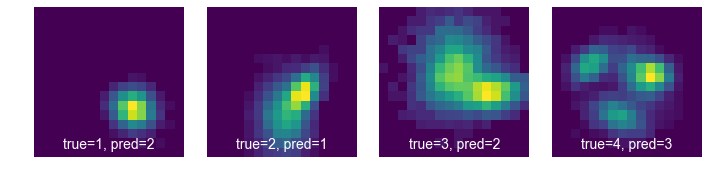

CPU times: user 3min 22s, sys: 504 ms, total: 3min 23s
Wall time: 3min 21s


In [25]:
%time nsrc_knc_test = test_sk_classification(neighbors.KNeighborsClassifier())

The columns correspond to 1-4 true sources in the image. The rows show:
 - Predictions for the training images.
 - Predictions for the test images.
 - Examples of test images that were misclassified.
 
Compare the predictions for training data (first row) and test data (second row) to assess how well the model generalizes.

It is always a good idea to scan some failures on the test data (last row) and check that they make sense. This is an excellent way to find bugs and get ideas for improving the algorithm.

The [confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) provides a useful classifier summary, indexed by the true value (row) and predicted value (column).  Use a pandas DataFrame to display the matrix:

In [26]:
pd.DataFrame(
    metrics.confusion_matrix(nsrc_true_test, nsrc_knc_test),
    index=[f'true={i}' for i in range(1, 5)],
    columns=[f'pred={i}' for i in range(1, 5)])

,pred=1,pred=2,pred=3,pred=4
true=1,7424,67,2,0
true=2,1095,1995,78,3
true=3,67,820,328,35
true=4,6,181,294,105


### Random Forest Classification

Train a "forest" of decision trees, each using a different subset of the data, then combine their predictions for an overall classification (or regression).

For details see [wikipedia](https://en.wikipedia.org/wiki/Random_forest) and the [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

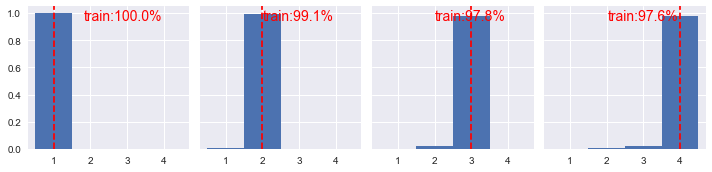

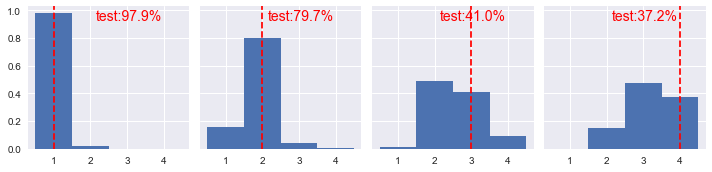

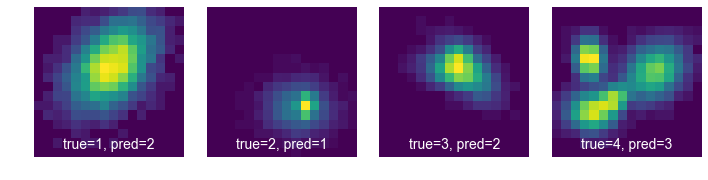

CPU times: user 2.78 s, sys: 29.7 ms, total: 2.81 s
Wall time: 2.81 s


In [27]:
%time nsrc_rfc_test = test_sk_classification(ensemble.RandomForestClassifier())

### Gradient Boosted Tree Classifier

Find an optimized combination of low-accuracy decision trees to give a "boosted" high-accuracy result.

For details, see [wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting) and the [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

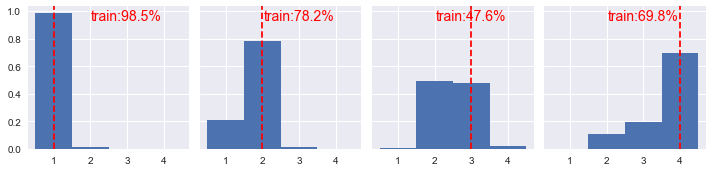

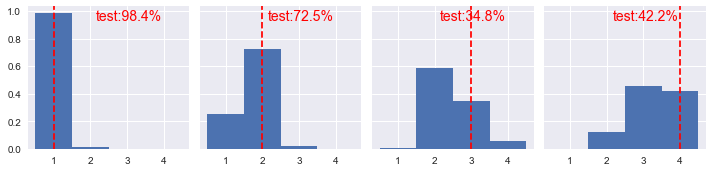

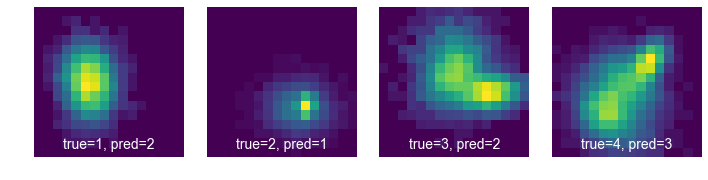

CPU times: user 5min 2s, sys: 44 s, total: 5min 46s
Wall time: 2min 1s


In [28]:
%time nsrc_gbc_test = test_sk_classification(ensemble.GradientBoostingClassifier())

### Support Vector Machine Classification

Find optimal hyperplanes to separate the different labels.

For details, see [wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine) and the [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

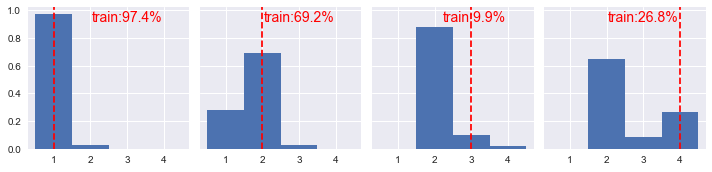

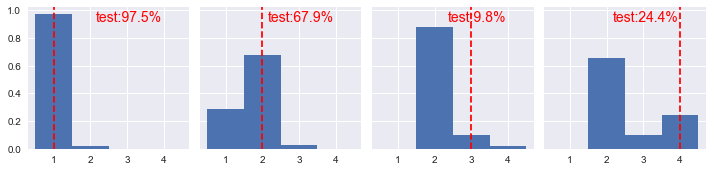

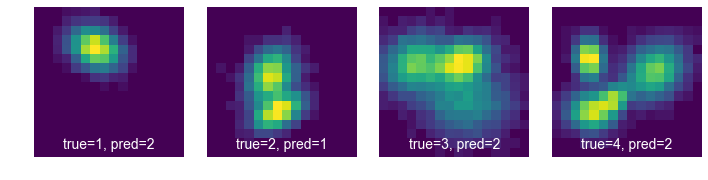

CPU times: user 42.5 s, sys: 357 ms, total: 42.8 s
Wall time: 41.7 s


In [29]:
%time nsrc_svc_test = test_sk_classification(svm.LinearSVC())

## Regression

The primary sklearn test metric for regression problems is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$, for which the goal is $R^2 = 1$. A method that always returns the mean of the target value has $R^2 = 0$, and $R^2 < 0$ is possible for even worse methods.

We will use the following driver to quickly test different methods:

In [30]:
def test_sk_regression(
    method, train_data=df_iso_train_normed, test_data=df_iso_test_normed):
    # Fit normalized training images.
    fit = method.fit(train_data, e_scaled_train)
    # Get predicted shear for training images.
    e_train = e_scaler.inverse_transform(fit.predict(train_data))
    # Get predicted shear for test images.
    e_test = e_scaler.inverse_transform(fit.predict(test_data))
    # Plot results.
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
    plot_regression(e_train, e_true_train, label='train:', ax=ax[0])
    plot_regression(e_test, e_true_test, label='test:', ax=ax[1])
    plt.tight_layout()

### Nearest-Neighbors Regression

CPU times: user 29.7 s, sys: 341 ms, total: 30 s
Wall time: 28.8 s


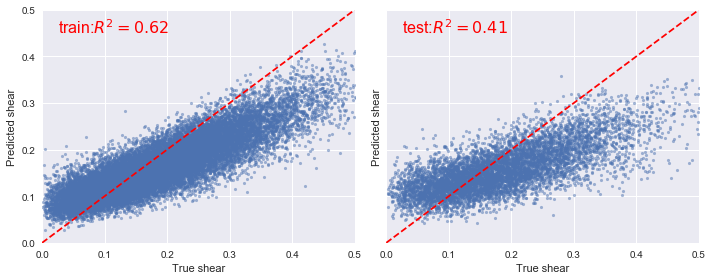

In [31]:
%time test_sk_regression(neighbors.KNeighborsRegressor())

### Random-Forest Regression

CPU times: user 25.1 s, sys: 66.7 ms, total: 25.2 s
Wall time: 25.2 s


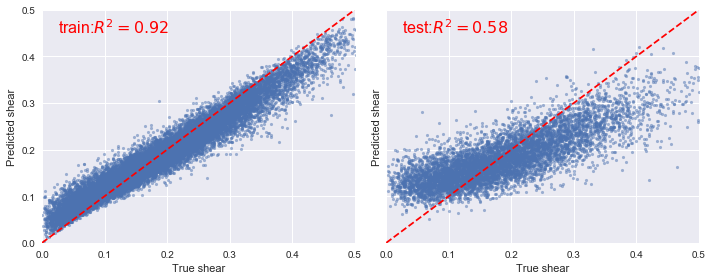

In [32]:
%time test_sk_regression(ensemble.RandomForestRegressor(random_state=123))

### Gradient Boosted Tree Regression

CPU times: user 13.3 s, sys: 56.5 ms, total: 13.3 s
Wall time: 13.3 s


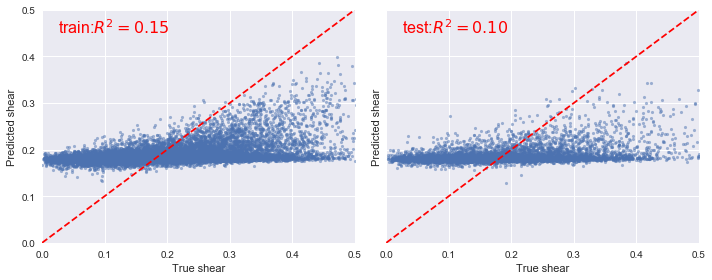

In [33]:
%time test_sk_regression(ensemble.GradientBoostingRegressor(random_state=123))

### Support Vector Machine Regression

CPU times: user 6.8 s, sys: 113 ms, total: 6.91 s
Wall time: 6.58 s


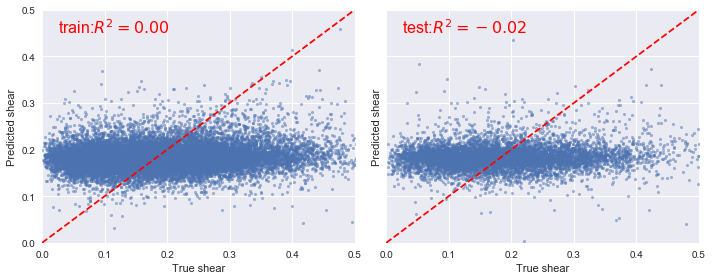

In [34]:
%time test_sk_regression(svm.LinearSVR(random_state=123))

### Linear Regression

Linear regression generalizes the idea of fitting 2D points to a straight line. It is very fast and robust and often a good choice for establishing a baseline with a straightforward method.

However, linear regression is not useful for this problem because our target values are not even approximately linear in the pixel values.

For more details, see [wikipedia](https://en.wikipedia.org/wiki/Linear_regression) and the [sklearn docs](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).

The use of regularization terms and basis functions make linear regression surprisingly useful for other problems.

CPU times: user 633 ms, sys: 123 ms, total: 755 ms
Wall time: 202 ms


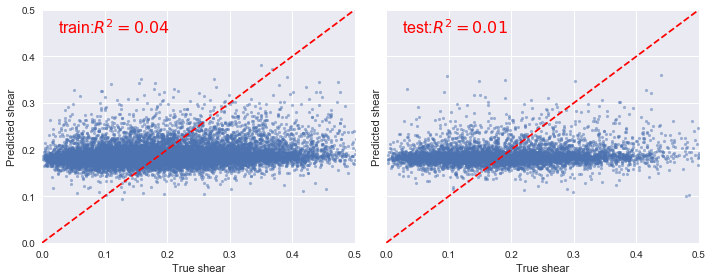

In [35]:
%time test_sk_regression(linear_model.LinearRegression())

## Hyperparameter Tuning

Most sklearn algorithms come with a lot of parameters that are not determined from your data and must be specified by hand. These are effectively model **hyperparameters**.

Most hyperparameters have sensible default values, but you should not assume they are either optimal (or even valid) for your particular problem.

Ask yourself these questions whenever using an algorithm and need to trust the results:
 - Do the predictions depend on the parameter? If not, you are done.
 - If so, what value of the parameter gives the best performance? (measured with cross validation)
 - How did you pick your baseline value of the parameter? (imagine this is a question from your paper referee)
 - Are there any values of the parameter that have good generalization but contradict your baseline results?
 
As a practical matter, **K-folding** and **cross-validation** help answer the second question.

### K-Folding

Cross validation goes beyond a simple train-test split by repeating the split multiple times and combining the (correlated) results. There are different strategies for picking the different splits, but [K-folding](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is a good all-around choice:
 - Specify the number $k$ of splits (folds) to use.
 - The data is split into $k$ (almost) equal independent subsets.
 - Each subset is used for testing once, with the remaining subsets used for training.
 
The result is $k$ different train-test splits using a test fraction $1/k$.  For example, with $N=10$ samples and $k=3$ folds, the subsets are:

In [36]:
kfold = model_selection.KFold(n_splits=3)
[tuple(split[1]) for split in kfold.split(range(10))]

[(0, 1, 2, 3), (4, 5, 6), (7, 8, 9)]

### Cross Validation

The [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function automates the k-folding and scoring process, and outputs both train and test $R^2$ scores, as well as CPU times, for each split.

Note that you could pass all of the data here (instead of just the training data) since the train/test split is performed (multiple times) internally. However, it is better practice to run cross validation on a fixed fraction of your data, and reserve the rest for a test that is independent 

In [37]:
model_selection.cross_validate(
    ensemble.RandomForestClassifier(random_state=123),
    df_img_normed, nsrc_true, cv=3, return_train_score=False)

{'fit_time': array([1.72725821, 1.74513197, 1.72587705]),
 'score_time': array([0.04288197, 0.03995705, 0.04524612]),
 'test_score': array([0.83945284, 0.84455244, 0.84073452])}

Cross validation works the same for classification and regression, but with different score functions:

In [38]:
model_selection.cross_validate(
    svm.LinearSVR(random_state=123),
    df_iso_normed, e_scaled, cv=3, return_train_score=False)

{'fit_time': array([5.7358973 , 5.643785  , 5.53444481]),
 'score_time': array([0.01218891, 0.0110178 , 0.01508498]),
 'test_score': array([-0.03197861, -0.04203342, -0.02634648])}

### Hyperparameter Grid Search

The [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function puts all the pieces together to:
 - scan a grid of one or more hyperparameters,
 - use cross validation with K-folding to score each point in the hyperparameter grid,
 - find the hyperparameters with the best mean cross validation score.
 
Note that you should ideally reserve some test data that is not used for cross validation, to ensure that your test predictions do not suffer from any hyperparameter overfitting. You can accomplish this by only using the original training data for the grid search.

In [39]:
cv = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=123),
    {'n_estimators': (5, 10, 20)},
    cv=3, return_train_score=False)
fit = cv.fit(df_img_train_normed, nsrc_true_train)

The results contain details on the timing and performance of each k-fold split, so are quite verbose:

In [40]:
fit.cv_results_

{'mean_fit_time': array([0.62944841, 1.24954279, 2.47507453]),
 'std_fit_time': array([0.00944877, 0.00888701, 0.01733404]),
 'mean_score_time': array([0.01626007, 0.03332639, 0.06196737]),
 'std_score_time': array([0.00045486, 0.00084894, 0.00497238]),
 'param_n_estimators': masked_array(data=[5, 10, 20],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 5}, {'n_estimators': 10}, {'n_estimators': 20}],
 'split0_test_score': array([0.81945444, 0.84017279, 0.85041197]),
 'split1_test_score': array([0.81128, 0.83104, 0.84552]),
 'split2_test_score': array([0.81366509, 0.83734699, 0.84966797]),
 'mean_test_score': array([0.8148    , 0.83618667, 0.84853333]),
 'std_test_score': array([0.00343239, 0.00381771, 0.00215229]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

If you just want the "best" hyperparameters:

In [41]:
best = np.argmax(fit.cv_results_['mean_test_score'])
print(fit.cv_results_['params'][best])

{'n_estimators': 20}


Note that, in this case, the results tell us that increasing `n_estimators` from its default value of 10 improves the performance, so our next step should be to see how far we can go with this.

### Acknowledgement:
**H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).**